In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal, halfnorm, norm
from scipy.optimize import minimize
from scipy.linalg import cho_factor, cho_solve

# ------------------------- Utility --------------------------
def fill_lower_triangular_columnwise(matrix, values):
    """Fill lower triangle col-wise (including diag) from a 1D vector."""
    val_index = 0
    for j in range(matrix.shape[1]):
        for i in range(j, matrix.shape[0]):
            if val_index < len(values):
                matrix[i, j] = values[val_index]
                val_index += 1
    return matrix

def mean_TE_halfnormal(sigma_u):
    """Unconditional mean TE = E[exp(-U)] for U ~ |N(0, sigma_u^2)|."""
    return 2.0 * np.exp(sigma_u**2 / 2.0) * norm.cdf(-sigma_u)

def make_spd_from_symmetric(A, jitter=1e-6):
    """Ensure SPD by minimal diagonal jitter if needed."""
    A = 0.5 * (A + A.T)
    try:
        cho_factor(A, lower=False, check_finite=False)
        return A
    except Exception:
        diag = np.diag(A)
        bump = jitter if diag.size == 0 else max(jitter, 1e-6 * (1.0 + np.max(np.abs(diag))))
        while True:
            A_try = A + bump * np.eye(A.shape[0])
            try:
                cho_factor(A_try, lower=False, check_finite=False)
                return A_try
            except Exception:
                bump *= 10.0

# ------------------------- L2 (reduced form) ----------------
def lnL2_vec(sigee, etas):
    """
    Per-observation log-likelihood for eta_i ~ N(0, Sigma_ee).
    Returns vector of length n (omits -k/2 log(2π)).
    """
    cF = cho_factor(sigee, lower=False, check_finite=False)  # Σ = UᵀU
    U = cF[0]
    logdet = 2.0 * np.sum(np.log(np.diag(U)))
    x = cho_solve(cF, etas.T, check_finite=False).T          # Σ^{-1} η_i
    quad = np.einsum('ij,ij->i', etas, x)                    # η_iᵀ Σ^{-1} η_i
    return -0.5 * logdet - 0.5 * quad

# ------------------------- L1 (book-consistent; σ_v & λ_c) --------------
def lnL1_vec(beta, sig_ev, sigee, log_sigma_v, log_lambda_c, y, X, etas):
    """
    LIML-1 kernel with (log σ_v, log λ_c) where λ_c = σ_u / σ_c and
      σ_c^2 = σ_v^2 - Σ_{vη} Σ_{ηη}^{-1} Σ_{ηv} = (Σ_{ηv})ᵀ Σ_{ηη}^{-1} Σ_{ηv} subtracted from σ_v^2.

    Parameters:
      beta     : structural coefficients (nX,)
      sig_ev   : stores Σ_{ηv} (k2,)   [NOTE: vector of length k2]
      sigee    : Σ_{ηη} (k2×k2)
      log_sigma_v, log_lambda_c: scalars
      y, X, etas: data

    Returns per-observation contributions to ln L1.
    """
    # Ensure SPD (symmetric positive definite) and factorize Σ_{ηη}
    sigee = make_spd_from_symmetric(sigee)
    cF = cho_factor(sigee, lower=False, check_finite=False)

    # w = Σ_{ηη}^{-1} Σ_{ηv}
    sig_ev = np.asarray(sig_ev).reshape(-1)            # Σ_{ηv}, shape (k2,)
    w = cho_solve(cF, sig_ev, check_finite=False)      # shape (k2,)

    # μ_ci and shifted residual r
    muci = etas @ w
    r = y - X @ beta - muci

    # scales via constraint
    sigma_v = np.exp(log_sigma_v)
    correction = float(np.dot(sig_ev, w))              # Σ_{ηv}ᵀ Σ_{ηη}^{-1} Σ_{ηv}
    sigma_c2 = sigma_v**2 - correction
    if sigma_c2 <= 1e-12:                              # outside admissible region
        return np.full(y.shape[0], -1e20)

    sigma_c = np.sqrt(sigma_c2)
    lam_c   = np.exp(log_lambda_c)                     # = σ_u / σ_c
    sigma_u = lam_c * sigma_c

    sigma2 = sigma_c2 + sigma_u**2
    sigma  = np.sqrt(sigma2)

    # log Φ( - λ_c r / σ ) in stable form
    z = -(lam_c / sigma) * r
    lPhi = norm.logcdf(z)

    return -0.5 * np.log(sigma2) - 0.5 * (r**2 / sigma2) + lPhi

# ------------------------- Full log-density -------------------
def AppLogDen_LIML(coefs, y, X, Z):
    """
    Parameter layout:
      beta          (nX)
      p1            (nZ), p2 (nZ)          -- reduced-form means (Π columns)
      sig_ev        (k2,)  (stores Σ_{ηv})
      sigee_params  (k2*(k2+1)/2,)         -- lower-tri entries for 2x2 Σ_{ηη}
      log_sigma_v, log_lambda_c            -- σ_v > 0,  λ_c = σ_u/σ_c > 0

    Returns per-observation lnL1 + lnL2 (vector).
    """
    nX, nZ = X.shape[1], Z.shape[1]
    beta = coefs[:nX]
    p1 = coefs[nX : nX + nZ]
    p2 = coefs[nX + nZ : nX + 2*nZ]
    sig_ev = coefs[nX + 2*nZ : nX + 2*nZ + 2]                 # k2=2
    sigee_arr = coefs[nX + 2*nZ + 2 : -2]
    log_sigma_v = coefs[-2]
    log_lambda_c = coefs[-1]

    # Σ_{ηη} from params
    sigee = fill_lower_triangular_columnwise(np.zeros((2, 2)), sigee_arr)
    sigee = make_spd_from_symmetric(sigee + sigee.T - np.diag(np.diag(sigee)))

    # Reduced-form residuals η_i = x2_i − Z Π
    z1 = Z @ p1.reshape(-1, 1)
    z2 = Z @ p2.reshape(-1, 1)
    etas = X[:, [2, 3]] - np.hstack([z1, z2])

    # L1 + L2 (per i)
    l1 = lnL1_vec(beta, sig_ev, sigee, log_sigma_v, log_lambda_c, y, X, etas)
    l2 = lnL2_vec(sigee, etas)
    return l1 + l2

def AppLoglikelihood_LIML(coefs, y, X, Z):
    return -np.sum(AppLogDen_LIML(coefs, y, X, Z))

def AppEstimate_LIML(y, X, Z):
    """
    Estimate LIML parameters with (log σ_v, log λ_c) parameterization.
    Returns: theta_hat (full vector), None
    """
    nX, nZ = X.shape[1], Z.shape[1]
    beta0 = [2.0, 1.0, 0.5, 0.8]      # true beta in DGP
    # p1 (5) + p2 (5) initial Π columns
    pi0  = [0.6, 0.9, 1.1, -0.7, 0.4, 0.2, -0.4, 0.8, 1.0, -0.8]
    sig_ev0  = [0.5, 0.3]             # initial Σ_{ηv} vector (k2=2)
    # lower-tri entries for Σ_{ηη} (2x2): [s11, s21, s22]
    sigee0  = [1.0, 0.4, 1.0]

    # Logs for σ_v and λ_c
    log_sigma_v0  = np.log(1.0)       # near true σ_v
    # For your DGP: σ_c^2 = 1 - correction ≈ 0.738 → σ_c ≈ 0.859, λ_c ≈ 0.25/0.859 ≈ 0.291
    log_lambda_c0 = np.log(0.30)

    theta0 = np.array(beta0 + pi0 + sig_ev0 + sigee0 + [log_sigma_v0, log_lambda_c0])

    result = minimize(
        AppLoglikelihood_LIML, theta0, args=(y, X, Z),
        method='L-BFGS-B', tol=1e-6, options={"maxiter": 2000}
    )
    return result.x, None

# ------------------------- MLE (no endog) --------------------
def lnL_MLE(coefs, y, X):
    """Half-normal SFA: coefs = [beta..., log_sigma_u, log_sigma_v]."""
    beta = coefs[:-2]
    sigma_u = np.exp(coefs[-2])
    sigma_v = np.exp(coefs[-1])

    sigma = np.sqrt(sigma_u**2 + sigma_v**2)
    lam = sigma_u / sigma_v

    eps = y - X @ beta
    eps_sigma = eps / sigma

    term1 = np.log(2.0 / sigma)
    term2 = norm.logpdf(eps_sigma)
    term3 = norm.logcdf(-lam * eps_sigma)
    return -np.sum(term1 + term2 + term3)

def estimate_TE(y, X, theta):
    """
    Battese–Coelli TE_i = E[exp(-U_i) | eps_i] for half-normal inefficiency.
    theta = [beta..., log_sigma_u, log_sigma_v]
    Stable log-CDF implementation.
    """
    beta = theta[:-2]
    sigma_u = np.exp(theta[-2])
    sigma_v = np.exp(theta[-1])

    eps = y - X @ beta
    sigma2 = sigma_u**2 + sigma_v**2
    mu_star = -eps * (sigma_u**2) / sigma2
    sigma_star = (sigma_u * sigma_v) / np.sqrt(sigma2)

    a = mu_star / (sigma_star + 1e-15)
    log_ratio = norm.logcdf(a - sigma_star) - norm.logcdf(a)
    te = np.exp(-mu_star + 0.5 * sigma_star**2 + log_ratio)
    return te

def AppEstimate_MLE(y, X):
    """Return [beta..., sigma_u, sigma_v] on original scale."""
    beta0 = np.linalg.lstsq(X, y, rcond=None)[0]
    resid = y - X @ beta0
    s2 = np.var(resid)
    sigma_u0 = np.sqrt(max(s2/2, 1e-2))
    sigma_v0 = np.sqrt(max(s2/2, 1e-2))

    bounds = [(None, None)]*len(beta0) + [(-5, 5), (-5, 5)]  # logs bounded
    theta0 = np.concatenate([beta0, [np.log(sigma_u0)], [np.log(sigma_v0)]])

    result = minimize(
        lnL_MLE, theta0, args=(y, X),
        method='L-BFGS-B', bounds=bounds,
        options={'maxiter': 1000, 'ftol': 1e-8}
    )
    if not result.success:
        theta0 = np.concatenate([beta0, [np.log(0.2)], [np.log(1.0)]])
        result = minimize(lnL_MLE, theta0, args=(y, X), method='L-BFGS-B', bounds=bounds)

    theta = result.x
    return np.concatenate([theta[:-2], [np.exp(theta[-2]), np.exp(theta[-1])]])

# ------------------------- LIML unpack for TE & reporting ----------------
def liml_unpack_for_te(liml_est, y, X, Z):
    """
    From full LIML theta (with log σ_v, log λ_c), compute:
      beta_hat, sigma_u_hat, sigma_v_hat, sigma_c_hat, mu_ci (n,)
    """
    nX, nZ = X.shape[1], Z.shape[1]
    beta_hat = liml_est[:nX]
    p1_hat   = liml_est[nX : nX + nZ]
    p2_hat   = liml_est[nX + nZ : nX + 2*nZ]
    sig_ev_hat = liml_est[nX + 2*nZ : nX + 2*nZ + 2]         # stores Σ_{ηv}
    sigee_arr = liml_est[nX + 2*nZ + 2 : -2]
    log_sigma_v = liml_est[-2]
    log_lambda_c = liml_est[-1]

    # Σ_{ηη}
    sigee = fill_lower_triangular_columnwise(np.zeros((2, 2)), sigee_arr)
    sigee = make_spd_from_symmetric(sigee + sigee.T - np.diag(np.diag(sigee)))
    cF = cho_factor(sigee, lower=False, check_finite=False)

    # η and μ_ci
    z1_hat = Z @ p1_hat.reshape(-1, 1)
    z2_hat = Z @ p2_hat.reshape(-1, 1)
    etas_hat = X[:, [2, 3]] - np.hstack([z1_hat, z2_hat])

    w = cho_solve(cF, sig_ev_hat, check_finite=False)        # Σ_{ηη}^{-1} Σ_{ηv}
    mu_ci = etas_hat @ w

    # σ's
    sigma_v_hat = np.exp(log_sigma_v)
    lam_c_hat   = np.exp(log_lambda_c)
    correction  = float(np.dot(sig_ev_hat, w))
    sigma_c_hat2 = sigma_v_hat**2 - correction
    sigma_c_hat  = np.sqrt(max(sigma_c_hat2, 1e-15))
    sigma_u_hat  = lam_c_hat * sigma_c_hat

    return beta_hat, sigma_u_hat, sigma_v_hat, sigma_c_hat, mu_ci



In [ ]:
# ------------------------- Simulation Core -------------------
def run_comparison_simulations(num_sims=100, n=800):
    # True DGP params
    true_sigma_u = 0.25
    true_sigma_v = 1.0
    true_TE_mean = mean_TE_halfnormal(true_sigma_u)

    Pi_fixed = np.array([
        [0.6, 0.2], [0.9, -0.4], [1.1, 0.8], [-0.7, 1.0], [0.4, -0.8]
    ])  # shape (5,2)

    liml_rows, mle_rows = [], []
    N_OUT = 7  # β0, β1, β2, β3, σ_u, σ_v, TE_mean

    for sim in range(num_sims):
        rng = np.random.default_rng(12345 + sim)

        # Data gen
        X1 = rng.normal(0, 1, (n, 1))
        W  = rng.normal(0, 1, (n, 3))
        Z  = np.hstack([np.ones((n, 1)), X1, W])     # (n,5)

        # (v, eta) joint Gaussian with 2 endogenous regressors (eta shape (n,2))
        Sigma = np.array([[1.0, 0.5, 0.3],
                          [0.5, 1.0, 0.4],
                          [0.3, 0.4, 1.0]])
        v_eta = rng.multivariate_normal(np.zeros(3), Sigma, size=n)
        v, eta = v_eta[:, 0], v_eta[:, 1:]
        X2 = Z @ Pi_fixed + eta

        # Half-normal inefficiency
        u = halfnorm.rvs(scale=true_sigma_u, size=n, random_state=12345 + sim)
        eps = v - u

        X_big = np.hstack([np.ones((n, 1)), X1, X2])  # (n,4)
        beta_true = np.array([2.0, 1.0, 0.5, 0.8])
        y = X_big @ beta_true + eps

        # ----- LIML -----
        try:
            liml_est, _ = AppEstimate_LIML(y, X_big, Z)
            beta_hat, sig_u_hat, sig_v_hat, sig_c_hat, mu_ci = liml_unpack_for_te(liml_est, y, X_big, Z)

            # TE via shifted residual r = y - Xβ - μ_ci, using (σ_u, σ_c)
            r = y - X_big @ beta_hat - mu_ci
            sigma2 = sig_u_hat**2 + sig_c_hat**2
            mu_star = -r * (sig_u_hat**2) / sigma2
            sigma_star = (sig_u_hat * sig_c_hat) / np.sqrt(sigma2)

            a = mu_star / (sigma_star + 1e-15)
            log_ratio = norm.logcdf(a - sigma_star) - norm.logcdf(a)
            te_liml = np.exp(-mu_star + 0.5 * sigma_star**2 + log_ratio)
            te_mean_liml = np.mean(te_liml)

            liml_rows.append(list(beta_hat[:4]) + [sig_u_hat, sig_v_hat, te_mean_liml])
        except Exception:
            liml_rows.append([np.nan] * N_OUT)

        # ----- MLE (baseline, no endogeneity correction) -----
        try:
            mle_est = AppEstimate_MLE(y, X_big)  # [β..., σ_u, σ_v]
            theta_mle = np.concatenate([mle_est[:4], [np.log(mle_est[4])], [np.log(mle_est[5])]])
            te_mle = estimate_TE(y, X_big, theta_mle)
            te_mean_mle = np.mean(te_mle)
            mle_rows.append(mle_est.tolist() + [te_mean_mle])
        except Exception:
            mle_rows.append([np.nan] * N_OUT)

    # ---------- Results compilation (vectorized; consistent for all params) ----------
    liml_arr = np.asarray(liml_rows, dtype=float)   # shape: (S, 7)
    mle_arr  = np.asarray(mle_rows,  dtype=float)

    params = ['β0', 'β1', 'β2', 'β3', 'σ_u', 'σ_v', 'TE']
    true_vals = np.array([2.0, 1.0, 0.5, 0.8, true_sigma_u, true_sigma_v, true_TE_mean], dtype=float)

    def summarize(est_arr, truth_vec):
        means = np.empty_like(truth_vec, dtype=float)
        bias  = np.empty_like(truth_vec, dtype=float)
        rmse  = np.empty_like(truth_vec, dtype=float)
        for j in range(truth_vec.shape[0]):
            col = est_arr[:, j]
            m = np.isfinite(col)
            if m.any():
                diff = col[m] - truth_vec[j]
                means[j] = col[m].mean()
                bias[j]  = np.abs(diff).mean()
                rmse[j]  = np.sqrt((diff**2).mean())
            else:
                means[j] = bias[j] = rmse[j] = np.nan
        return means, bias, rmse

    LIML_Mean, LIML_Bias, LIML_RMSE = summarize(liml_arr, true_vals)
    MLE_Mean,  MLE_Bias,  MLE_RMSE  = summarize(mle_arr,  true_vals)

    results = pd.DataFrame({
        'Parameter': params,
        'True Value': true_vals,
        'LIML_Mean': LIML_Mean,
        'MLE_Mean':  MLE_Mean,
        'LIML_Bias': LIML_Bias,
        'MLE_Bias':  MLE_Bias,
        'LIML_RMSE': LIML_RMSE,
        'MLE_RMSE':  MLE_RMSE,
    }).set_index('Parameter')

    return results

# ------------------------- Run -------------------------------
if __name__ == "__main__":
    pd.set_option('display.float_format', '{:.4f}'.format)
    results = run_comparison_simulations(num_sims=100, n=800)
    print("\n=== Simulation Results (num_sims=100, n=800) ===")
    print(results)



=== Simulation Results (num_sims=100, n=800) ===
           True Value  LIML_Mean  MLE_Mean  LIML_Bias  MLE_Bias  LIML_RMSE  \
Parameter                                                                    
β0             2.0000     2.0016    1.9290     0.0222    0.2186     0.0329   
β1             1.0000     0.9996    0.8801     0.0223    0.1200     0.0334   
β2             0.5000     0.5026    0.6702     0.0154    0.1702     0.0217   
β3             0.8000     0.8009    0.8813     0.0142    0.0813     0.0203   
σ_u            0.2500     0.2584    0.3086     0.0085    0.2640     0.0096   
σ_v            1.0000     1.0030    0.9216     0.0149    0.0785     0.0214   
TE             0.8281     0.8232    0.8202     0.0049    0.1453     0.0056   

           MLE_RMSE  
Parameter            
β0           0.2390  
β1           0.1257  
β2           0.1714  
β3           0.0830  
σ_u          0.2981  
σ_v          0.0920  
TE           0.1554  


Running simulations for n = 100 ...
Running simulations for n = 200 ...
Running simulations for n = 400 ...
Running simulations for n = 800 ...
✅ All simulations completed.


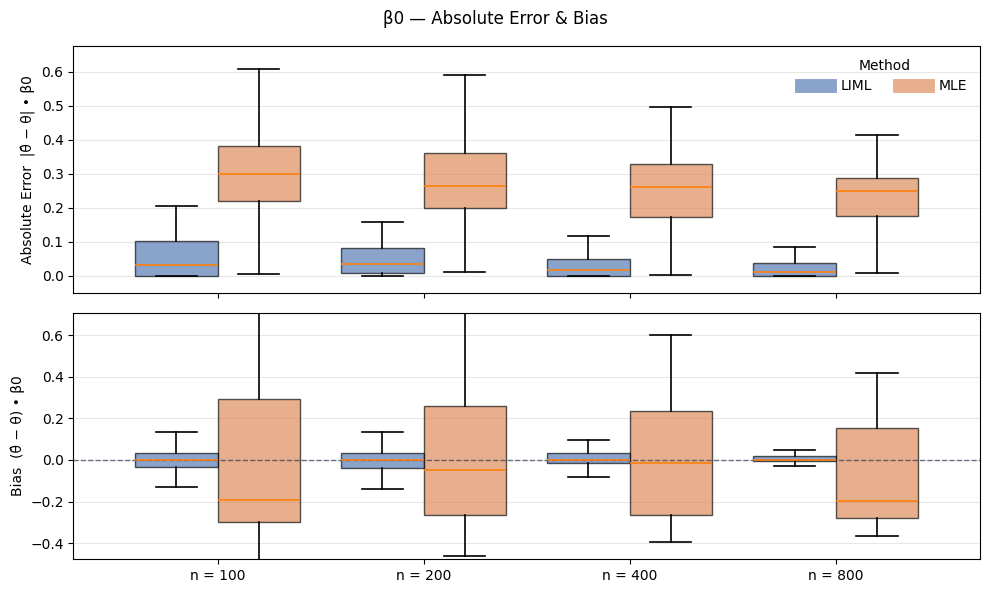

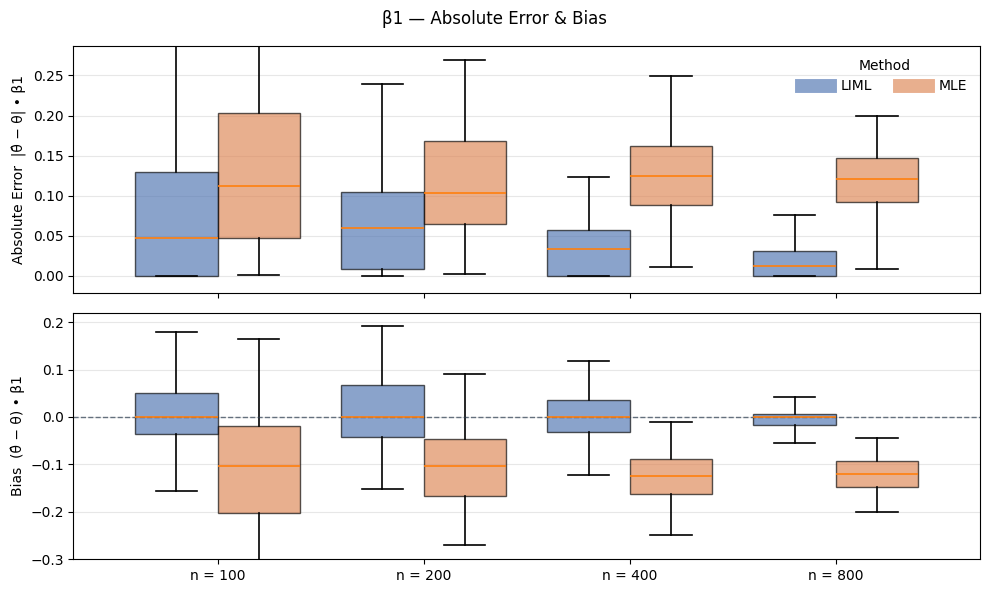

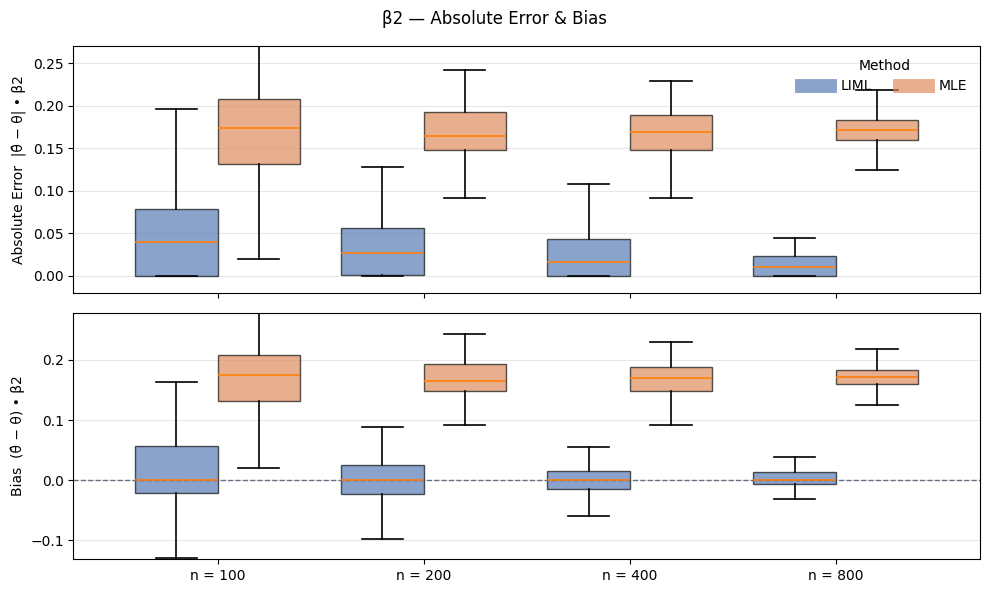

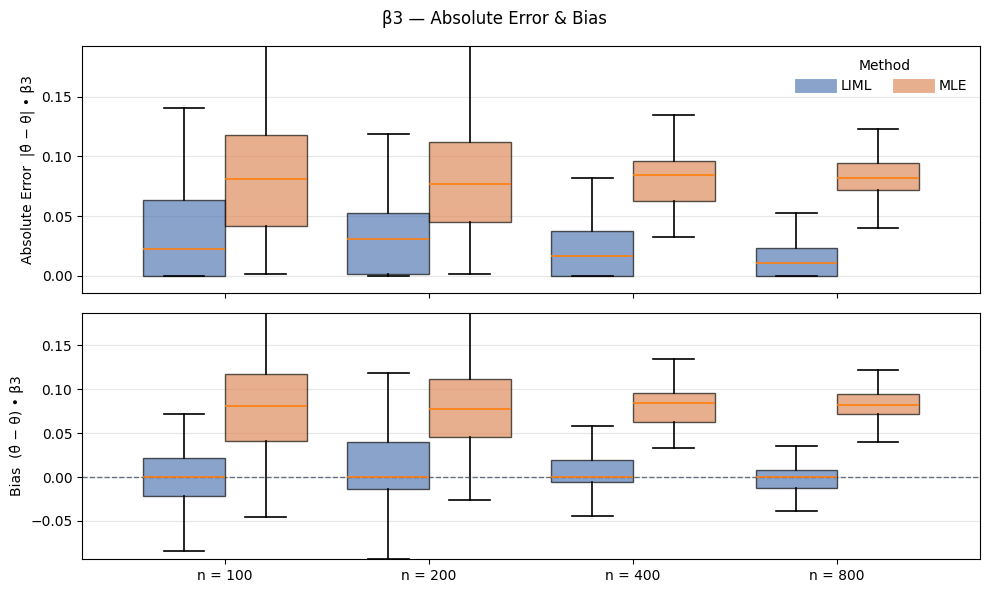

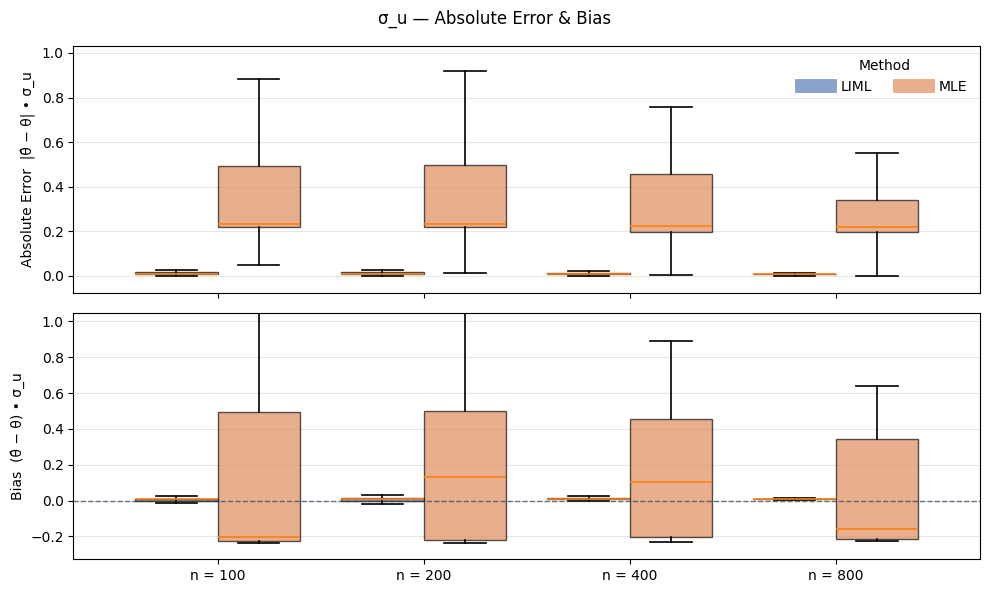

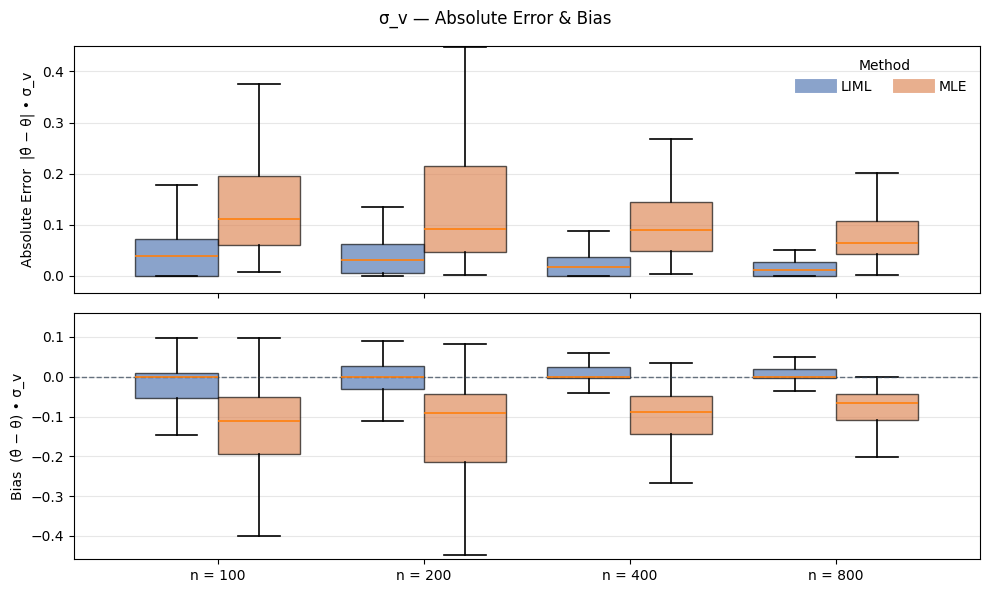

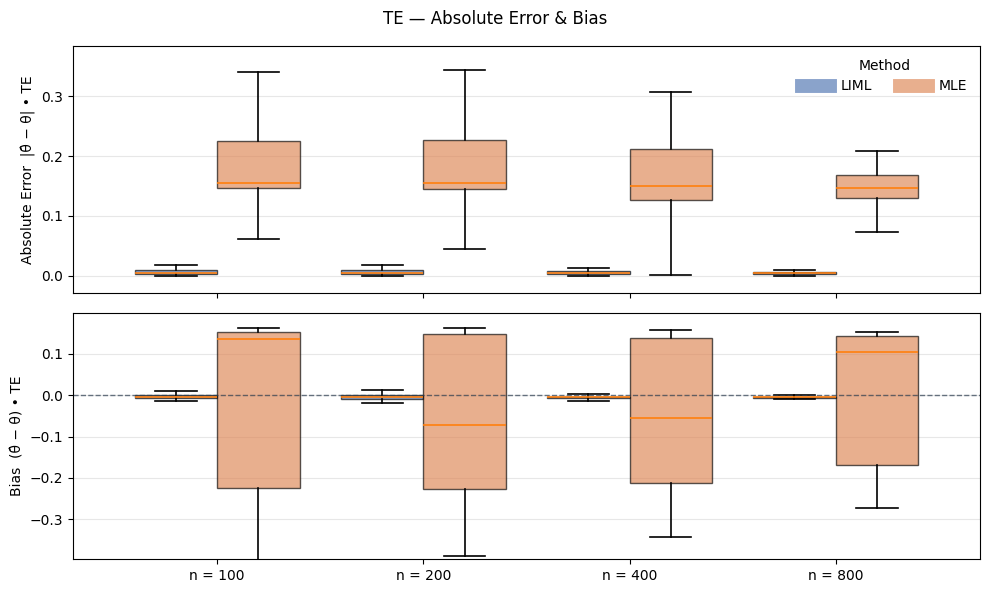

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, halfnorm, norm
from scipy.optimize import minimize
from scipy.linalg import cho_factor, cho_solve

# ------------------------- Utility --------------------------
def fill_lower_triangular_columnwise(matrix, values):
    """Fill lower triangle col-wise (including diag) from a 1D vector."""
    val_index = 0
    for j in range(matrix.shape[1]):
        for i in range(j, matrix.shape[0]):
            if val_index < len(values):
                matrix[i, j] = values[val_index]
                val_index += 1
    return matrix

def mean_TE_halfnormal(sigma_u):
    """Unconditional mean TE = E[exp(-U)] for U ~ |N(0, sigma_u^2)|."""
    return 2.0 * np.exp(sigma_u**2 / 2.0) * norm.cdf(-sigma_u)

def make_spd_from_symmetric(A, jitter=1e-6):
    """Ensure SPD by minimal diagonal jitter if needed."""
    A = 0.5 * (A + A.T)
    try:
        cho_factor(A, lower=False, check_finite=False)
        return A
    except Exception:
        diag = np.diag(A)
        bump = jitter if diag.size == 0 else max(jitter, 1e-6 * (1.0 + np.max(np.abs(diag))))
        while True:
            A_try = A + bump * np.eye(A.shape[0])
            try:
                cho_factor(A_try, lower=False, check_finite=False)
                return A_try
            except Exception:
                bump *= 10.0

# ------------------------- L2 (reduced form) ----------------
def lnL2_vec(sigee, etas):
    """
    Per-observation log-likelihood for eta_i ~ N(0, Sigma_ee).
    Returns vector of length n (omits -k/2 log(2π)).
    """
    cF = cho_factor(sigee, lower=False, check_finite=False)  # Σ = UᵀU
    U = cF[0]
    logdet = 2.0 * np.sum(np.log(np.diag(U)))
    x = cho_solve(cF, etas.T, check_finite=False).T          # Σ^{-1} η_i
    quad = np.einsum('ij,ij->i', etas, x)                    # η_iᵀ Σ^{-1} η_i
    return -0.5 * logdet - 0.5 * quad

# ------------------------- L1 (book-consistent; σ_v & λ_c) --------------
def lnL1_vec(beta, sig_ev, sigee, log_sigma_v, log_lambda_c, y, X, etas):
    """
    LIML-1 kernel with (log σ_v, log λ_c) where λ_c = σ_u / σ_c and
      σ_c^2 = σ_v^2 - Σ_{vη} Σ_{ηη}^{-1} Σ_{ηv}.
    """
    # Ensure SPD and factorize Σ_{ηη}
    sigee = make_spd_from_symmetric(sigee)
    cF = cho_factor(sigee, lower=False, check_finite=False)

    # w = Σ_{ηη}^{-1} Σ_{ηv}
    sig_ev = np.asarray(sig_ev).reshape(-1)            # Σ_{ηv}, shape (k2,)
    w = cho_solve(cF, sig_ev, check_finite=False)      # shape (k2,)

    # μ_ci and shifted residual r
    muci = etas @ w
    r = y - X @ beta - muci

    # scales via constraint
    sigma_v = np.exp(log_sigma_v)
    correction = float(np.dot(sig_ev, w))              # Σ_{ηv}ᵀ Σ_{ηη}^{-1} Σ_{ηv}
    sigma_c2 = sigma_v**2 - correction
    if sigma_c2 <= 1e-12:                              # outside admissible region
        return np.full(y.shape[0], -1e20)

    sigma_c = np.sqrt(sigma_c2)
    lam_c   = np.exp(log_lambda_c)                     # = σ_u / σ_c
    sigma_u = lam_c * sigma_c

    sigma2 = sigma_c2 + sigma_u**2
    sigma  = np.sqrt(sigma2)

    # log Φ( - λ_c r / σ ) in stable form
    z = -(lam_c / sigma) * r
    lPhi = norm.logcdf(z)

    return -0.5 * np.log(sigma2) - 0.5 * (r**2 / sigma2) + lPhi

# ------------------------- Full log-density -------------------
def AppLogDen_LIML(coefs, y, X, Z):
    """
    Parameter layout:
      beta (nX)
      p1 (nZ), p2 (nZ)                 -- reduced-form means (Π columns)
      sig_ev (k2,)                     -- stores Σ_{ηv}
      sigee_params (k2*(k2+1)/2,)      -- lower-tri entries for 2x2 Σ_{ηη}
      log_sigma_v, log_lambda_c        -- σ_v > 0, λ_c = σ_u/σ_c > 0
    """
    nX, nZ = X.shape[1], Z.shape[1]
    beta = coefs[:nX]
    p1 = coefs[nX : nX + nZ]
    p2 = coefs[nX + nZ : nX + 2*nZ]
    sig_ev = coefs[nX + 2*nZ : nX + 2*nZ + 2]                 # k2=2
    sigee_arr = coefs[nX + 2*nZ + 2 : -2]
    log_sigma_v = coefs[-2]
    log_lambda_c = coefs[-1]

    # Σ_{ηη} from params
    sigee = fill_lower_triangular_columnwise(np.zeros((2, 2)), sigee_arr)
    sigee = make_spd_from_symmetric(sigee + sigee.T - np.diag(np.diag(sigee)))

    # Reduced-form residuals η_i = x2_i − Z Π
    z1 = Z @ p1.reshape(-1, 1)
    z2 = Z @ p2.reshape(-1, 1)
    etas = X[:, [2, 3]] - np.hstack([z1, z2])

    # L1 + L2 (per i)
    l1 = lnL1_vec(beta, sig_ev, sigee, log_sigma_v, log_lambda_c, y, X, etas)
    l2 = lnL2_vec(sigee, etas)
    return l1 + l2

def AppLoglikelihood_LIML(coefs, y, X, Z):
    return -np.sum(AppLogDen_LIML(coefs, y, X, Z))

def AppEstimate_LIML(y, X, Z):
    """
    Estimate LIML parameters with (log σ_v, log λ_c) parameterization.
    Returns: theta_hat (full vector), None
    """
    nX, nZ = X.shape[1], Z.shape[1]
    beta0 = [2.0, 1.0, 0.5, 0.8]      # true beta in DGP
    # p1 (5) + p2 (5) initial Π columns
    pi0  = [0.6, 0.9, 1.1, -0.7, 0.4, 0.2, -0.4, 0.8, 1.0, -0.8]
    sig_ev0  = [0.5, 0.3]             # initial Σ_{ηv} vector (k2=2)
    # lower-tri entries for Σ_{ηη} (2x2): [s11, s21, s22]
    sigee0  = [1.0, 0.4, 1.0]

    # Logs for σ_v and λ_c
    log_sigma_v0  = np.log(1.0)       # near true σ_v
    # For your DGP: σ_c^2 = 1 - correction ≈ 0.738 → σ_c ≈ 0.859, λ_c ≈ 0.25/0.859 ≈ 0.291
    log_lambda_c0 = np.log(0.30)

    theta0 = np.array(beta0 + pi0 + sig_ev0 + sigee0 + [log_sigma_v0, log_lambda_c0])

    result = minimize(
        AppLoglikelihood_LIML, theta0, args=(y, X, Z),
        method='L-BFGS-B', tol=1e-6, options={"maxiter": 2000}
    )
    return result.x, None

# ------------------------- MLE (no endog) --------------------
def lnL_MLE(coefs, y, X):
    """Half-normal SFA: coefs = [beta..., log_sigma_u, log_sigma_v]."""
    beta = coefs[:-2]
    sigma_u = np.exp(coefs[-2])
    sigma_v = np.exp(coefs[-1])

    sigma = np.sqrt(sigma_u**2 + sigma_v**2)
    lam = sigma_u / sigma_v

    eps = y - X @ beta
    eps_sigma = eps / sigma

    term1 = np.log(2.0 / sigma)
    term2 = norm.logpdf(eps_sigma)
    term3 = norm.logcdf(-lam * eps_sigma)
    return -np.sum(term1 + term2 + term3)

def estimate_TE(y, X, theta):
    """
    Battese–Coelli TE_i = E[exp(-U_i) | eps_i] for half-normal inefficiency.
    theta = [beta..., log_sigma_u, log_sigma_v]
    Stable log-CDF implementation.
    """
    beta = theta[:-2]
    sigma_u = np.exp(theta[-2])
    sigma_v = np.exp(theta[-1])

    eps = y - X @ beta
    sigma2 = sigma_u**2 + sigma_v**2
    mu_star = -eps * (sigma_u**2) / sigma2
    sigma_star = (sigma_u * sigma_v) / np.sqrt(sigma2)

    a = mu_star / (sigma_star + 1e-15)
    log_ratio = norm.logcdf(a - sigma_star) - norm.logcdf(a)
    te = np.exp(-mu_star + 0.5 * sigma_star**2 + log_ratio)
    return te

def AppEstimate_MLE(y, X):
    """Return [beta..., sigma_u, sigma_v] on original scale."""
    beta0 = np.linalg.lstsq(X, y, rcond=None)[0]
    resid = y - X @ beta0
    s2 = np.var(resid)
    sigma_u0 = np.sqrt(max(s2/2, 1e-2))
    sigma_v0 = np.sqrt(max(s2/2, 1e-2))

    bounds = [(None, None)]*len(beta0) + [(-5, 5), (-5, 5)]  # logs bounded
    theta0 = np.concatenate([beta0, [np.log(sigma_u0)], [np.log(sigma_v0)]])

    result = minimize(
        lnL_MLE, theta0, args=(y, X),
        method='L-BFGS-B', bounds=bounds,
        options={'maxiter': 1000, 'ftol': 1e-8}
    )
    if not result.success:
        theta0 = np.concatenate([beta0, [np.log(0.2)], [np.log(1.0)]])
        result = minimize(lnL_MLE, theta0, args=(y, X), method='L-BFGS-B', bounds=bounds)

    theta = result.x
    return np.concatenate([theta[:-2], [np.exp(theta[-2]), np.exp(theta[-1])]])

# ------------------------- LIML unpack for TE & reporting ----------------
def liml_unpack_for_te(liml_est, y, X, Z):
    """
    From full LIML theta (with log σ_v, log λ_c), compute:
      beta_hat, sigma_u_hat, sigma_v_hat, sigma_c_hat, mu_ci (n,)
    """
    nX, nZ = X.shape[1], Z.shape[1]
    beta_hat = liml_est[:nX]
    p1_hat   = liml_est[nX : nX + nZ]
    p2_hat   = liml_est[nX + nZ : nX + 2*nZ]
    sig_ev_hat = liml_est[nX + 2*nZ : nX + 2*nZ + 2]         # stores Σ_{ηv}
    sigee_arr = liml_est[nX + 2*nZ + 2 : -2]
    log_sigma_v = liml_est[-2]
    log_lambda_c = liml_est[-1]

    # Σ_{ηη}
    sigee = fill_lower_triangular_columnwise(np.zeros((2, 2)), sigee_arr)
    sigee = make_spd_from_symmetric(sigee + sigee.T - np.diag(np.diag(sigee)))
    cF = cho_factor(sigee, lower=False, check_finite=False)

    # η and μ_ci
    z1_hat = Z @ p1_hat.reshape(-1, 1)
    z2_hat = Z @ p2_hat.reshape(-1, 1)
    etas_hat = X[:, [2, 3]] - np.hstack([z1_hat, z2_hat])

    w = cho_solve(cF, sig_ev_hat, check_finite=False)        # Σ_{ηη}^{-1} Σ_{ηv}
    mu_ci = etas_hat @ w

    # σ's
    sigma_v_hat = np.exp(log_sigma_v)
    lam_c_hat   = np.exp(log_lambda_c)
    correction  = float(np.dot(sig_ev_hat, w))
    sigma_c_hat2 = sigma_v_hat**2 - correction
    sigma_c_hat  = np.sqrt(max(sigma_c_hat2, 1e-15))
    sigma_u_hat  = lam_c_hat * sigma_c_hat

    return beta_hat, sigma_u_hat, sigma_v_hat, sigma_c_hat, mu_ci

# ========================= ADDED: per-sim collection & plots =========================

PARAMS = ['β0', 'β1', 'β2', 'β3', 'σ_u', 'σ_v', 'TE']
TRUE_SIGMA_U = 0.25
TRUE_SIGMA_V = 1.0
NS = (100, 200, 400, 800)
NUM_SIMS = 100

def _simulate_linear_once(n, rng):
    """One DGP draw matching your existing Simulation Core."""
    # Instruments / regressors
    X1 = rng.normal(0, 1, (n, 1))
    W  = rng.normal(0, 1, (n, 3))
    Z  = np.hstack([np.ones((n, 1)), X1, W])     # (n,5)

    # Joint (v, eta)
    Sigma = np.array([[1.0, 0.5, 0.3],
                      [0.5, 1.0, 0.4],
                      [0.3, 0.4, 1.0]])
    v_eta = rng.multivariate_normal(np.zeros(3), Sigma, size=n)
    v, eta = v_eta[:, 0], v_eta[:, 1:]

    Pi_fixed = np.array([
        [0.6, 0.2], [0.9, -0.4], [1.1, 0.8], [-0.7, 1.0], [0.4, -0.8]
    ])
    X2 = Z @ Pi_fixed + eta

    # Inefficiency and error
    u = halfnorm.rvs(scale=TRUE_SIGMA_U, size=n, random_state=rng.integers(0, 2**31-1))
    eps = v - u

    # Structural model
    beta_true = np.array([2.0, 1.0, 0.5, 0.8])
    X_big = np.hstack([np.ones((n, 1)), X1, X2])  # (n,4)
    y = X_big @ beta_true + eps

    # Truths
    true_map = {
        'β0': beta_true[0], 'β1': beta_true[1], 'β2': beta_true[2], 'β3': beta_true[3],
        'σ_u': TRUE_SIGMA_U, 'σ_v': TRUE_SIGMA_V, 'TE': mean_TE_halfnormal(TRUE_SIGMA_U)
    }
    return y, X_big, Z, true_map

def collect_per_sim_linear(num_sims=NUM_SIMS, n=800):
    """
    Collect per-simulation estimates for methods = {LIML, MLE}.
    Returns long-format DataFrame with columns:
    n, sim, method, param, estimate, true, bias, abs_error
    """
    methods = ['LIML', 'MLE']
    rows = []

    for sim in range(num_sims):
        rng = np.random.default_rng(12345 + sim)
        y, X_big, Z, true_map = _simulate_linear_once(n, rng)

        # LIML
        liml_vals = [np.nan]*len(PARAMS)
        try:
            liml_est, _ = AppEstimate_LIML(y, X_big, Z)
            beta_hat, sig_u_hat, sig_v_hat, sig_c_hat, mu_ci = liml_unpack_for_te(liml_est, y, X_big, Z)
            r = y - X_big @ beta_hat - mu_ci
            sigma2 = sig_u_hat**2 + sig_c_hat**2
            mu_star = -r * (sig_u_hat**2) / (sigma2 + 1e-15)
            sigma_star = (sig_u_hat * sig_c_hat) / np.sqrt(sigma2 + 1e-15)
            a = mu_star / (sigma_star + 1e-15)
            log_ratio = norm.logcdf(a - sigma_star) - norm.logcdf(a)
            te_liml = np.exp(-mu_star + 0.5 * sigma_star**2 + log_ratio)
            te_mean_liml = np.mean(te_liml)
            liml_vals = list(beta_hat[:4]) + [float(sig_u_hat), float(sig_v_hat), float(te_mean_liml)]
        except Exception:
            pass

        # MLE
        mle_vals = [np.nan]*len(PARAMS)
        try:
            mle_est = AppEstimate_MLE(y, X_big)  # [β..., σ_u, σ_v]
            theta_mle = np.concatenate([mle_est[:4], [np.log(mle_est[4])], [np.log(mle_est[5])]])
            te_mle = estimate_TE(y, X_big, theta_mle)
            te_mean_mle = np.mean(te_mle)
            mle_vals = mle_est.tolist() + [float(te_mean_mle)]
        except Exception:
            pass

        est_by_method = {'LIML': liml_vals, 'MLE': mle_vals}
        for method in methods:
            est_list = est_by_method[method]
            for p, est_val in zip(PARAMS, est_list):
                t = float(true_map[p])
                if np.isfinite(est_val):
                    b = float(est_val) - t
                    rows.append({
                        'n': n, 'sim': sim, 'method': method, 'param': p,
                        'estimate': float(est_val), 'true': t,
                        'bias': b, 'abs_error': abs(b)
                    })
                else:
                    rows.append({
                        'n': n, 'sim': sim, 'method': method, 'param': p,
                        'estimate': np.nan, 'true': t, 'bias': np.nan, 'abs_error': np.nan
                    })
    return pd.DataFrame(rows)

def run_all_simulations(ns=NS, num_sims=NUM_SIMS):
    """Run all sample sizes and return one combined long DataFrame."""
    dfs = []
    for n in ns:
        print(f"Running simulations for n = {n} ...")
        dfs.append(collect_per_sim_linear(num_sims=num_sims, n=n))
    all_df = pd.concat(dfs, ignore_index=True)
    print("✅ All simulations completed.")
    return all_df

def boxplot_param_two_metrics_grouped_by_n(
    df,
    params=('β0','β1','β2','β3','σ_u','σ_v','TE'),
    methods_order=('LIML','MLE'),
    ns_sorted=None,
    save=False,
    out_dir="."
):
    """
    One figure per parameter with two rows:
      Row 1: Absolute Error  |θ̂−θ|
      Row 2: Bias            θ̂−θ
    x-axis: n (100, 200, 400, 800)
    For each n: side-by-side boxes for methods in methods_order.
    """
    import os
    import numpy as np
    import matplotlib.pyplot as plt

    if ns_sorted is None:
        ns_sorted = sorted(df['n'].unique())
    mlist = list(methods_order)
    colors = {'LIML': '#4C72B0', 'MLE': '#DD8452'}  # blue, orange (extend as needed)

    for p in params:
        dparam = df[df['param'] == p].copy()

        # --- plotting scaffold
        n_groups = len(ns_sorted)
        n_methods = len(mlist)
        group_width = 0.8
        box_width = group_width / n_methods
        offsets = np.linspace(-group_width/2 + box_width/2,
                              group_width/2 - box_width/2,
                              n_methods)
        x_centers = np.arange(n_groups)

        fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
        metrics = [('abs_error', 'Absolute Error  |θ̂ − θ|'),
                   ('bias',      'Bias  (θ̂ − θ)')]

        for ax, (metric, ylabel) in zip(axes, metrics):
            dmet = dparam[np.isfinite(dparam[metric])].copy()

            # robust y-lims per metric & parameter
            if len(dmet) > 0:
                yvals = dmet[metric].to_numpy()
                y_min = np.nanpercentile(yvals, 1)
                y_max = np.nanpercentile(yvals, 99)
                pad = 0.08 * max(y_max - y_min, 1e-12)
                ax.set_ylim(y_min - pad, y_max + pad)

            for mi, m in enumerate(mlist):
                data = []
                for n in ns_sorted:
                    vals = dmet[(dmet['n'] == n) & (dmet['method'] == m)][metric].values
                    data.append(vals)

                positions = x_centers + offsets[mi]
                bp = ax.boxplot(
                    data, positions=positions, widths=box_width,
                    showfliers=False, patch_artist=True
                )
                # color + styling
                for patch in bp['boxes']:
                    patch.set_facecolor(colors.get(m, 'gray'))
                    patch.set_alpha(0.65)
                for k in ('whiskers','caps','medians'):
                    for artist in bp[k]:
                        artist.set_linewidth(1.2)

            # cosmetics
            ax.set_ylabel(f"{ylabel} • {p}")
            ax.grid(True, axis='y', alpha=0.3)
            if metric == 'bias':
                ax.axhline(0, lw=1, ls='--', color='#2C3E50', alpha=0.7)

        # shared x labels & legend
        axes[-1].set_xticks(x_centers)
        axes[-1].set_xticklabels([f"n = {n}" for n in ns_sorted])
        handles = [plt.Line2D([0],[0], color=colors[m], lw=10, alpha=0.65, label=m) for m in mlist]
        axes[0].legend(handles=handles, title="Method", frameon=False, ncol=len(mlist), loc='upper right')

        fig.suptitle(f"{p} — Absolute Error & Bias", y=0.98)
        fig.tight_layout()

        if save:
            os.makedirs(out_dir, exist_ok=True)
            fig.savefig(os.path.join(out_dir, f"param_{p}_abs_error_bias.png"), dpi=200, bbox_inches='tight')
        plt.show()


# ------------------------- (Optional) Your original summary table -------------------
def run_comparison_simulations(num_sims=100, n=800):
    # True DGP params
    true_sigma_u = 0.25
    true_sigma_v = 1.0
    true_TE_mean = mean_TE_halfnormal(true_sigma_u)

    Pi_fixed = np.array([
        [0.6, 0.2], [0.9, -0.4], [1.1, 0.8], [-0.7, 1.0], [0.4, -0.8]
    ])  # shape (5,2)

    liml_rows, mle_rows = [], []
    N_OUT = 7  # β0, β1, β2, β3, σ_u, σ_v, TE_mean

    for sim in range(num_sims):
        rng = np.random.default_rng(12345 + sim)

        # Data gen
        X1 = rng.normal(0, 1, (n, 1))
        W  = rng.normal(0, 1, (n, 3))
        Z  = np.hstack([np.ones((n, 1)), X1, W])     # (n,5)

        # (v, eta) joint Gaussian with 2 endogenous regressors (eta shape (n,2))
        Sigma = np.array([[1.0, 0.5, 0.3],
                          [0.5, 1.0, 0.4],
                          [0.3, 0.4, 1.0]])
        v_eta = rng.multivariate_normal(np.zeros(3), Sigma, size=n)
        v, eta = v_eta[:, 0], v_eta[:, 1:]
        X2 = Z @ Pi_fixed + eta

        # Half-normal inefficiency
        u = halfnorm.rvs(scale=true_sigma_u, size=n, random_state=12345 + sim)
        eps = v - u

        X_big = np.hstack([np.ones((n, 1)), X1, X2])  # (n,4)
        beta_true = np.array([2.0, 1.0, 0.5, 0.8])
        y = X_big @ beta_true + eps

        # ----- LIML -----
        try:
            liml_est, _ = AppEstimate_LIML(y, X_big, Z)
            beta_hat, sig_u_hat, sig_v_hat, sig_c_hat, mu_ci = liml_unpack_for_te(liml_est, y, X_big, Z)

            # TE via shifted residual r = y - Xβ - μ_ci, using (σ_u, σ_c)
            r = y - X_big @ beta_hat - mu_ci
            sigma2 = sig_u_hat**2 + sig_c_hat**2
            mu_star = -r * (sig_u_hat**2) / sigma2
            sigma_star = (sig_u_hat * sig_c_hat) / np.sqrt(sigma2)

            a = mu_star / (sigma_star + 1e-15)
            log_ratio = norm.logcdf(a - sigma_star) - norm.logcdf(a)
            te_liml = np.exp(-mu_star + 0.5 * sigma_star**2 + log_ratio)
            te_mean_liml = np.mean(te_liml)

            liml_rows.append(list(beta_hat[:4]) + [sig_u_hat, sig_v_hat, te_mean_liml])
        except Exception:
            liml_rows.append([np.nan] * N_OUT)

        # ----- MLE (baseline, no endogeneity correction) -----
        try:
            mle_est = AppEstimate_MLE(y, X_big)  # [β..., σ_u, σ_v]
            theta_mle = np.concatenate([mle_est[:4], [np.log(mle_est[4])], [np.log(mle_est[5])]])
            te_mle = estimate_TE(y, X_big, theta_mle)
            te_mean_mle = np.mean(te_mle)
            mle_rows.append(mle_est.tolist() + [te_mean_mle])
        except Exception:
            mle_rows.append([np.nan] * N_OUT)

    # ---------- Results compilation ----------
    liml_arr = np.asarray(liml_rows, dtype=float)   # (S, 7)
    mle_arr  = np.asarray(mle_rows,  dtype=float)

    params = ['β0', 'β1', 'β2', 'β3', 'σ_u', 'σ_v', 'TE']
    true_vals = np.array([2.0, 1.0, 0.5, 0.8, true_sigma_u, true_sigma_v, true_TE_mean], dtype=float)

    def summarize(est_arr, truth_vec):
        means = np.empty_like(truth_vec, dtype=float)
        bias  = np.empty_like(truth_vec, dtype=float)
        rmse  = np.empty_like(truth_vec, dtype=float)
        for j in range(truth_vec.shape[0]):
            col = est_arr[:, j]
            m = np.isfinite(col)
            if m.any():
                diff = col[m] - truth_vec[j]
                means[j] = col[m].mean()
                bias[j]  = np.abs(diff).mean()
                rmse[j]  = np.sqrt((diff**2).mean())
            else:
                means[j] = bias[j] = rmse[j] = np.nan
        return means, bias, rmse

    LIML_Mean, LIML_Bias, LIML_RMSE = summarize(liml_arr, true_vals)
    MLE_Mean,  MLE_Bias,  MLE_RMSE  = summarize(mle_arr,  true_vals)

    results = pd.DataFrame({
        'Parameter': params,
        'True Value': true_vals,
        'LIML_Mean': LIML_Mean,
        'MLE_Mean':  MLE_Mean,
        'LIML_Bias': LIML_Bias,
        'MLE_Bias':  MLE_Bias,
        'LIML_RMSE': LIML_RMSE,
        'MLE_RMSE':  MLE_RMSE,
    }).set_index('Parameter')

    return results

# -------------------------------- MAIN ---------------------------------
if __name__ == "__main__":
    pd.set_option('display.float_format', '{:.4f}'.format)

    # 1) Run all n and collect per-simulation results
    df_all = run_all_simulations(ns=NS, num_sims=NUM_SIMS)

    # (Optional) Save the raw per-sim data
    # df_all.to_csv("per_sim_LIML_vs_MLE_all_ns.csv", index=False)

    # 2) Box plots: Abs Error then Bias
    # One plot (all n clustered) for each parameter — Absolute Error
# Using the df_all you already created from your simulations:
boxplot_param_two_metrics_grouped_by_n(
    df_all,
    params=('β0','β1','β2','β3','σ_u','σ_v','TE'),
    methods_order=('LIML','MLE'),
    save=False  # set True to write PNGs
)




    # 3) (Optional) Your aggregate summary table for one n (kept intact)
    # results = run_comparison_simulations(num_sims=100, n=800)
    # print("\n=== Simulation Results (num_sims=100, n=800) ===")
    # print(results)
